##### Colab-specific section (convert to code if needed)
import os
from google.colab import drive
drive.mount('/gdrive', force_remount=True)
!unlink "/content/coopmotion"
!ln -s "/gdrive/My Drive/coopmotion/" "/content/coopmotion"
!rm -r "/content/coopmotion/dataset (1)" "/content/coopmotion/dataset" "/content/coopmotion/models"

In [ ]:
!rm -r "/content/coopmotion/notebook/videos"

In [ ]:
#!mv -r "/content/videos" "/content/coopmotion/notebook/videos"
!mv "/content/videos" "/content/coopmotion/notebook/videos"

In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('../src')
sys.path.append('coopmotion/src') # COLAB
from matplotlib import pyplot as plt
import numpy as np
import torch
import time

# Learning

In [2]:
from task.square import SquareRun, proportional, sense, static_evenly_spread_task, static_zipf_task
controller = proportional
N = 4
sas, tas = 1, 1

In [3]:
#from task.fancy import animate_trace
#trace = run()
#animate_trace(trace, dt=0.05)

In [4]:
number_of_samples = 1000
valid_part = 0.2
keep = 0.2

# Centralized Network

In [5]:
task = static_evenly_spread_task(N, holonomic=True, spawn_area_size=sas, target_area_size=tas)
run = SquareRun(task, controller=controller, sensor=sense(), dt=0.1)

In [6]:
from task.dataset import generate_non_sequential_dataset, central_dataset
train_nseq = generate_non_sequential_dataset(run=run, number=number_of_samples, keep=keep, seed=0xDEADBEEF)
train_dataset, valid_dataset = central_dataset(train_nseq, valid_part)


train: x (806, 8)	y (806, 8)
valid: x (202, 8)	y (202, 8)


In [7]:
from keras_network import CentralizedNet
net = CentralizedNet(N, run.task.holonomic, patience=40)
history = net.train(epochs=200, train_dataset=train_dataset, valid_dataset=valid_dataset)

Train on 806 samples, validate on 202 samples
Epoch 1/200
806/806 [==============================] - 0s 178us/sample - loss: 0.0186 - mean_absolute_error: 0.1021 - val_loss: 0.0104 - val_mean_absolute_error: 0.0772
Epoch 2/200
806/806 [==============================] - 0s 40us/sample - loss: 0.0091 - mean_absolute_error: 0.0717 - val_loss: 0.0107 - val_mean_absolute_error: 0.0809
Epoch 3/200
806/806 [==============================] - 0s 31us/sample - loss: 0.0077 - mean_absolute_error: 0.0666 - val_loss: 0.0087 - val_mean_absolute_error: 0.0776
Epoch 4/200
806/806 [==============================] - 0s 33us/sample - loss: 0.0066 - mean_absolute_error: 0.0631 - val_loss: 0.0046 - val_mean_absolute_error: 0.0452
Epoch 5/200
806/806 [==============================] - 0s 30us/sample - loss: 0.0054 - mean_absolute_error: 0.0565 - val_loss: 0.0057 - val_mean_absolute_error: 0.0569
Epoch 6/200
806/806 [==============================] - 0s 31us/sample - loss: 0.0053 - mean_absolute_error: 0.056

806/806 [==============================] - 0s 30us/sample - loss: 1.9415e-04 - mean_absolute_error: 0.0104 - val_loss: 2.5345e-04 - val_mean_absolute_error: 0.0133
Epoch 95/200
806/806 [==============================] - 0s 31us/sample - loss: 2.1373e-04 - mean_absolute_error: 0.0113 - val_loss: 5.8143e-05 - val_mean_absolute_error: 0.0058
Epoch 96/200
806/806 [==============================] - 0s 32us/sample - loss: 1.9525e-04 - mean_absolute_error: 0.0105 - val_loss: 2.1360e-04 - val_mean_absolute_error: 0.0104
Epoch 97/200
806/806 [==============================] - 0s 33us/sample - loss: 1.9010e-04 - mean_absolute_error: 0.0109 - val_loss: 2.8236e-04 - val_mean_absolute_error: 0.0121
Epoch 98/200
806/806 [==============================] - 0s 33us/sample - loss: 1.9186e-04 - mean_absolute_error: 0.0102 - val_loss: 4.0796e-04 - val_mean_absolute_error: 0.0156
Epoch 99/200
806/806 [==============================] - 0s 32us/sample - loss: 2.0399e-04 - mean_absolute_error: 0.0106 - val_lo

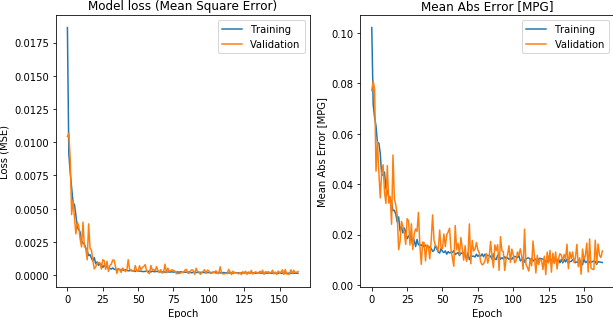

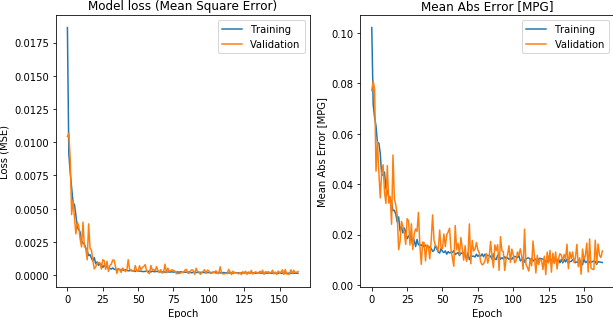

In [8]:
from task.fancy import training_plot
training_plot(history)

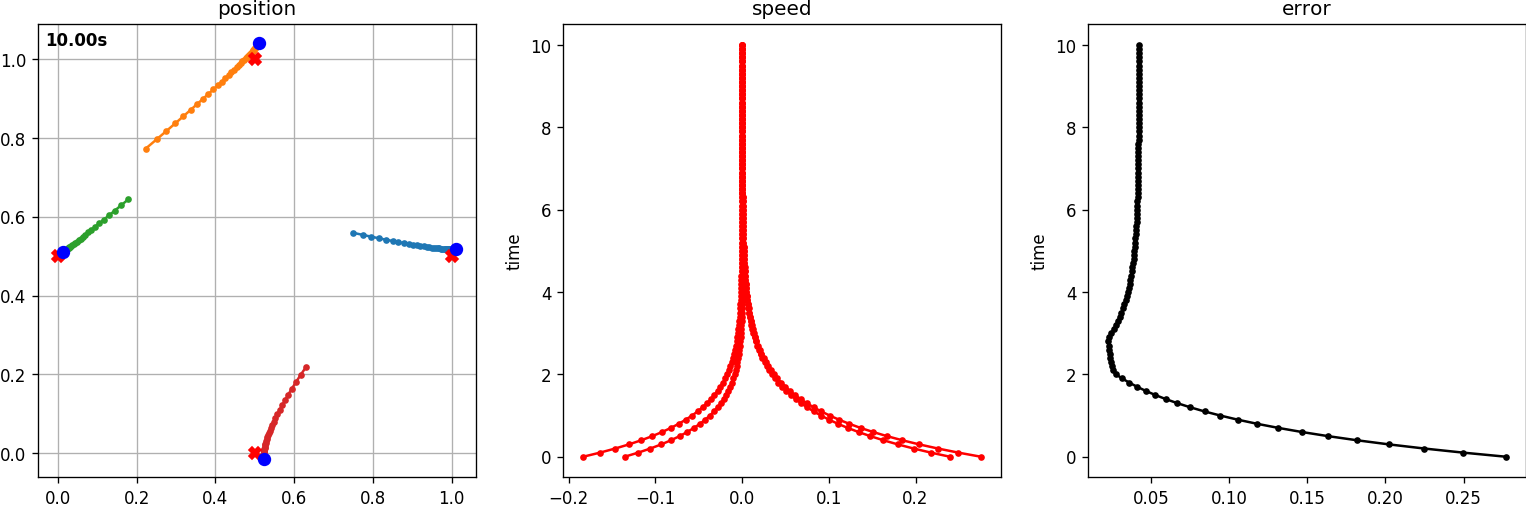

In [9]:
from task import Run
from task.fancy import plot_trace
net_controller = net.controller()
net_run = Run(task, sensor=run.sensor, dt=0.1, controller=net_controller)
c_trace = net_run(T=10, epsilon=0.01, seed=0xDEADBEEF)
plot_trace(c_trace, task)

In [10]:
from task.fancy import TracesAnimator
expert_trace = run(T=10, epsilon=0.01, seed=0xDEADBEEF)
TracesAnimator({'expert':expert_trace,'centralized': c_trace}, dt=0.05)

### How well are we controlling the agents?

In [11]:
from task.dataset import generate_sequential_dataset
comp_run, comp_duration, comp_steps = 100, 10, 50
exact_traces = generate_sequential_dataset(run, number=comp_run, duration=comp_duration, epsilon=0.01)
net_traces = generate_sequential_dataset(net_run, number=comp_run, duration=comp_duration, epsilon=0.01)
from task import prepare
exact_traces = [prepare(t, padding=True, steps=comp_steps) for t in exact_traces]
net_traces = [prepare(t, padding=True, steps=comp_steps) for t in net_traces]
time = exact_traces[0].time
exact_error = np.array([t.error for t in exact_traces])
net_error = np.array([t.error for t in net_traces])

Undefined 'steps': assuming 'number' specifies the number of runs (instead of desired samples)



Undefined 'steps': assuming 'number' specifies the number of runs (instead of desired samples)



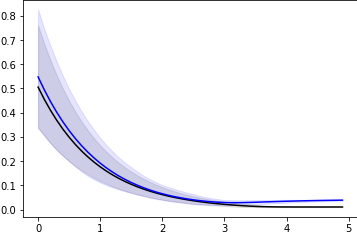

In [12]:
from task.fancy import plot_error
plot_error(time, exact_error, color='black', label='exact')
plot_error(time, net_error, color='blue', label='net')

## Distributed Network

In [13]:
from task.square import adaptive_evenly_spread_task, adaptive_zipf_task
task = adaptive_evenly_spread_task(N, holonomic=True, spawn_area_size=sas, target_area_size=tas)
run = SquareRun(task, controller=controller, sensor=sense(), dt=0.1)

In [14]:
number_of_samples = 10000
train_nseq = generate_non_sequential_dataset(run=run, number=number_of_samples, keep=keep)

In [15]:
from task.dataset import distributed_dataset
d_train_dataset, d_valid_dataset = distributed_dataset(train_nseq, valid_part)

x (32003, 6)	y (32003, 2)


In [16]:
from keras_network import DistributedNet
d_net = DistributedNet(run=run, patience=20)
history = d_net.train(epochs=500, train_dataset=d_train_dataset, valid_dataset=d_valid_dataset);

6
Train on 32003 samples, validate on 8001 samples
Epoch 1/500
32003/32003 [==============================] - 1s 39us/sample - loss: 0.0097 - mean_absolute_error: 0.0665 - val_loss: 0.0115 - val_mean_absolute_error: 0.0767
Epoch 2/500
32003/32003 [==============================] - 1s 34us/sample - loss: 0.0078 - mean_absolute_error: 0.0556 - val_loss: 0.0075 - val_mean_absolute_error: 0.0556
Epoch 3/500
32003/32003 [==============================] - 1s 32us/sample - loss: 0.0068 - mean_absolute_error: 0.0504 - val_loss: 0.0061 - val_mean_absolute_error: 0.0514
Epoch 4/500
32003/32003 [==============================] - 1s 33us/sample - loss: 0.0054 - mean_absolute_error: 0.0446 - val_loss: 0.0062 - val_mean_absolute_error: 0.0529
Epoch 5/500
32003/32003 [==============================] - 1s 30us/sample - loss: 0.0053 - mean_absolute_error: 0.0437 - val_loss: 0.0054 - val_mean_absolute_error: 0.0452
Epoch 6/500
32003/32003 [==============================] - 1s 30us/sample - loss: 0.0052 

Epoch 95/500
32003/32003 [==============================] - 1s 31us/sample - loss: 0.0025 - mean_absolute_error: 0.0223 - val_loss: 0.0026 - val_mean_absolute_error: 0.0227
Epoch 96/500
32003/32003 [==============================] - 1s 28us/sample - loss: 0.0025 - mean_absolute_error: 0.0223 - val_loss: 0.0026 - val_mean_absolute_error: 0.0234
Epoch 97/500
32003/32003 [==============================] - 1s 28us/sample - loss: 0.0025 - mean_absolute_error: 0.0221 - val_loss: 0.0030 - val_mean_absolute_error: 0.0307
Epoch 98/500
32003/32003 [==============================] - 1s 28us/sample - loss: 0.0025 - mean_absolute_error: 0.0221 - val_loss: 0.0029 - val_mean_absolute_error: 0.0295
Epoch 99/500
32003/32003 [==============================] - 1s 28us/sample - loss: 0.0025 - mean_absolute_error: 0.0222 - val_loss: 0.0027 - val_mean_absolute_error: 0.0251
Epoch 100/500
32003/32003 [==============================] - 1s 28us/sample - loss: 0.0025 - mean_absolute_error: 0.0220 - val_loss: 0.

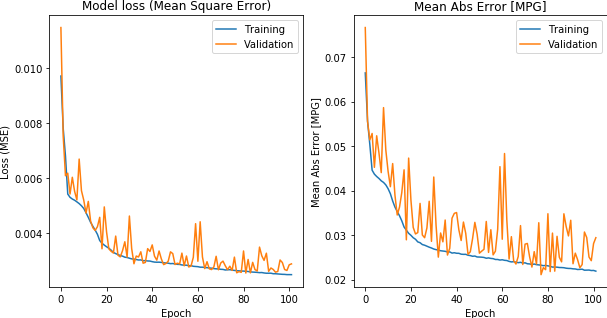

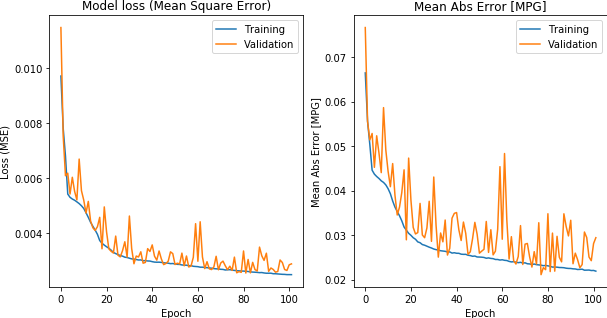

In [17]:
training_plot(history)

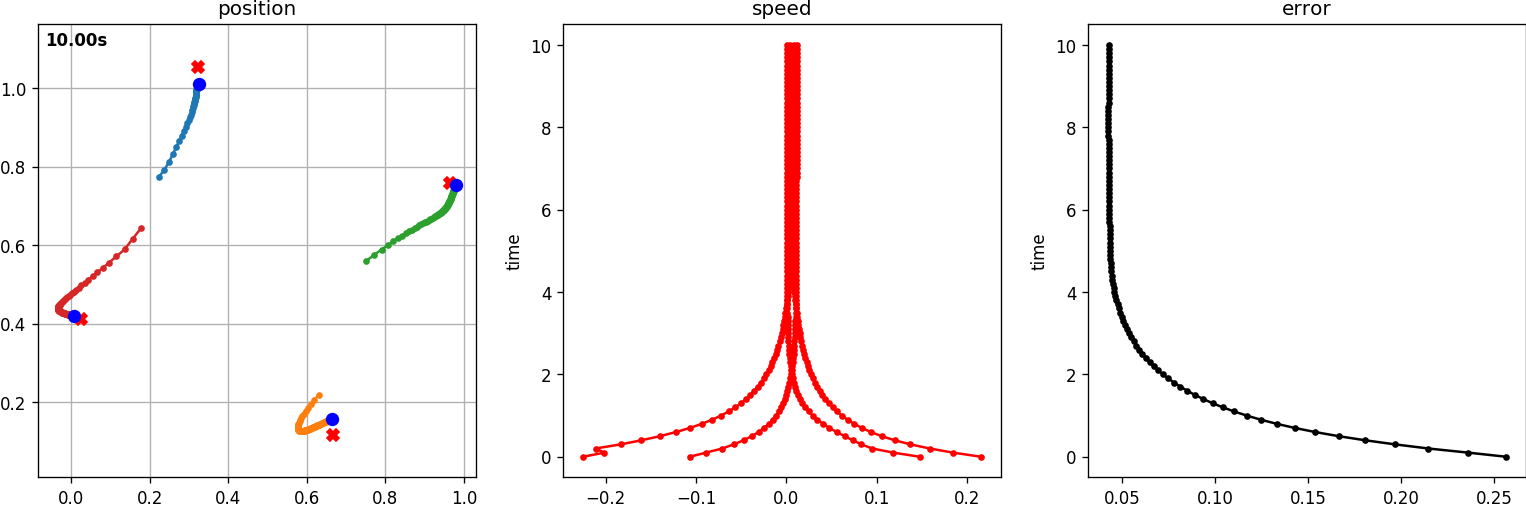

In [18]:
d_net_controller = d_net.controller()
d_net_run = Run(task, sensor=run.sensor, dt=0.1, controller=d_net_controller)
d_trace = d_net_run(T=10, epsilon=0.01, seed=0xDEADBEEF)
plot_trace(d_trace, task)

In [19]:
expert_trace = run(T=10, epsilon=0.01, seed=0xDEADBEEF)
TracesAnimator({'expert':expert_trace,'centralized': c_trace, 'distributed': d_trace}, dt=0.05)

In [20]:
d_net_traces = generate_sequential_dataset(d_net_run, number=100, duration=10, epsilon=0.01)
d_net_traces = [prepare(t, padding=True, steps=50) for t in d_net_traces]
d_net_error = np.array([t.error for t in d_net_traces])

Undefined 'steps': assuming 'number' specifies the number of runs (instead of desired samples)



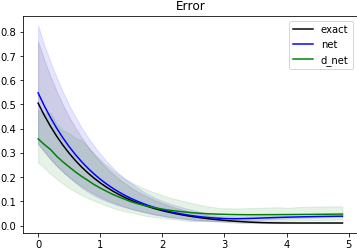

In [21]:
plot_error(time, exact_error, color='black', label='exact')
plot_error(time, net_error, color='blue', label='net')
plot_error(time, d_net_error, color='green', label='d_net')
plt.legend()
plt.title('Error');

## Distributed Communicating Network

In [22]:
from task.square import SquareRun
task = adaptive_evenly_spread_task(N, spawn_area_size=sas, target_area_size=tas, holonomic=True)
run = SquareRun(task, controller=controller, sensor=sense(robot_range=10), dt=0.1)

In [23]:
steps = 2
number_of_samples = 10000
train_traces = generate_sequential_dataset(run=run, number=number_of_samples, steps=steps, keep=keep)
test_traces = generate_sequential_dataset(run=run, number=number_of_samples, steps=steps, keep=keep)

In [24]:
from task.dataset import sequence_dataset
cd_train_dataset = sequence_dataset(train_traces)
cd_test_dataset = sequence_dataset(test_traces)
list(np.unique([x[0].shape[0] for x in cd_train_dataset]))

[2]

In [25]:
from com_network import ComNet
from pytorch_network import train_net
cd_net = ComNet(N=N, broadcast=2)
cd_training_loss, cd_testing_loss = [], []

In [26]:
train_net(epochs=10, net=cd_net, train_dataset=cd_train_dataset, test_dataset=cd_test_dataset, batch_size=1, 
          training_loss=cd_training_loss, testing_loss=cd_testing_loss);

100%|██████████| 10/10 [08:13<00:00, 49.05s/it]


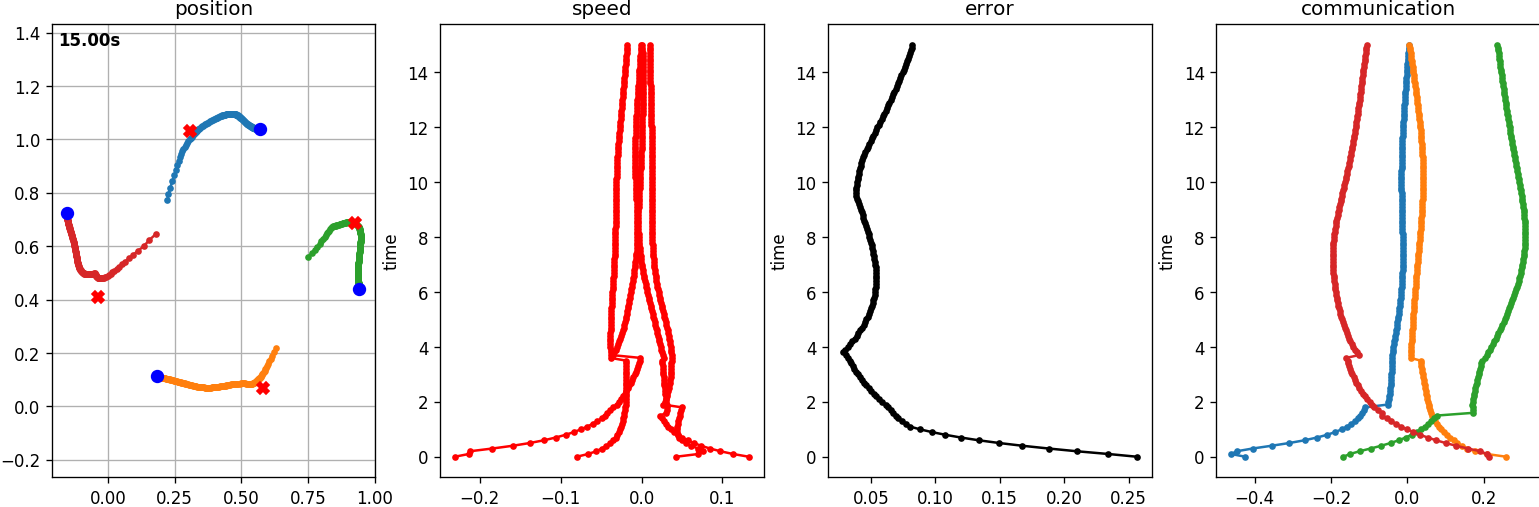

In [27]:
cd_net_controller = cd_net.controller()
cd_net_run = Run(task, sensor=run.sensor, dt=0.1, controller=cd_net_controller)
cd_trace = cd_net_run(T=15, seed=0xDEADBEEF)
expert_trace = run(T=15, seed=0xDEADBEEF)
plot_trace(cd_trace,task)

In [28]:
# animate_trace(trace, robot_range=20, dt= 0.05)
traces_dict = {'expert':expert_trace,'centralized (static)': c_trace, 
               'distributed': d_trace, 'distributed (comm)': cd_trace}
TracesAnimator(traces_dict, robot_range=10, dt=0.05)

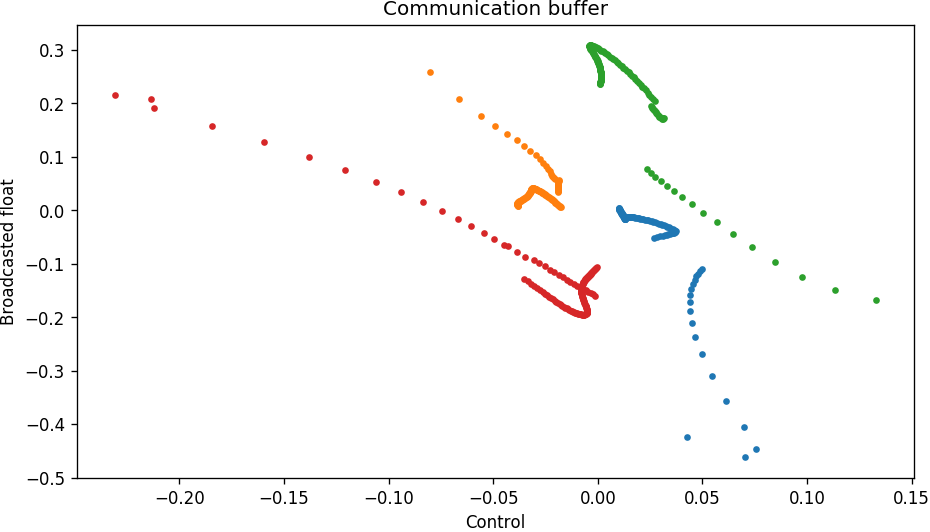

In [32]:
fig = plt.figure(figsize=(9, 5), dpi=120)
plt.plot(cd_trace.control[:,:,0], cd_trace.communication[:,0,:], '.');
plt.xlabel("Control")
plt.ylabel("Broadcasted float")
plt.title('Communication buffer');

In [30]:
cd_net_traces = generate_sequential_dataset(cd_net_run, number=100, duration=5, epsilon=0.01)
cd_net_traces = [prepare(t, padding=True, steps=50) for t in cd_net_traces]
cd_net_error = np.array([t.error for t in cd_net_traces])

Undefined 'steps': assuming 'number' specifies the number of runs (instead of desired samples)



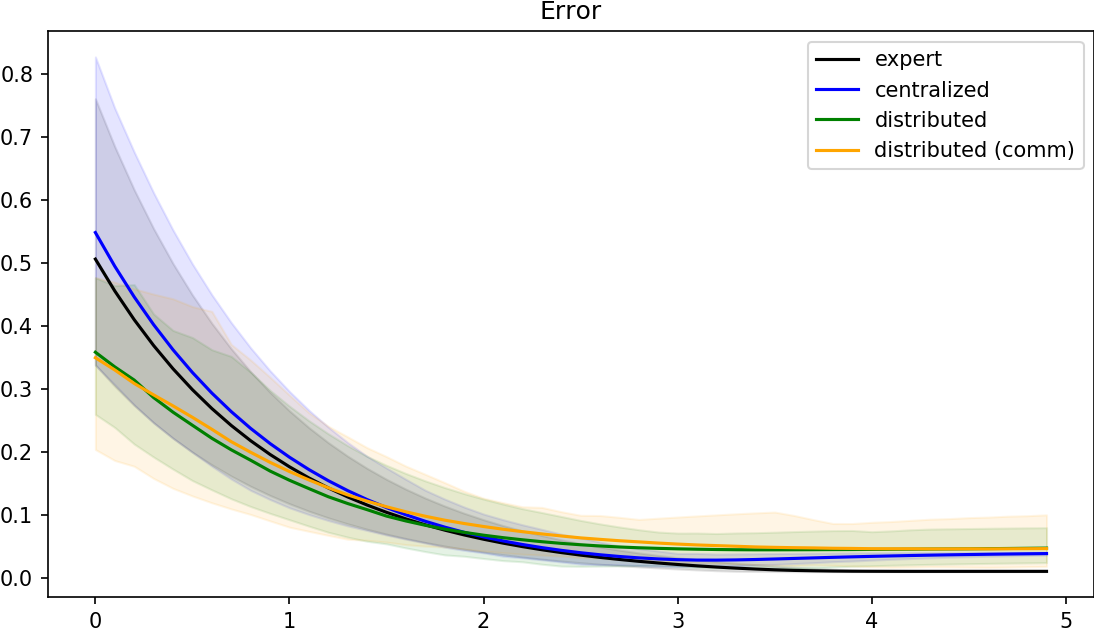

In [31]:
fig = plt.figure(figsize=(9, 5), dpi=150)
plot_error(time, exact_error, color='black', label='expert')
plot_error(time, net_error, color='blue', label='centralized')
plot_error(time, d_net_error, color='green', label='distributed')
plot_error(time, cd_net_error, color='orange', label='distributed (comm)')
plt.legend()
plt.title('Error');